In [14]:
import numpy as np
import astropy
from astropy.stats import mad_std
import glob
from astropy.io import fits
from matplotlib import pyplot as plt 
from astropy import units as u
from photutils import DAOStarFinder


# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

### Importing Test Data

Importing open-cluster data from brightspace and using DAO source detection. 

In [2]:
# image = fits.open(file_names[i])
# print(repr(image[0].header['INSFILTE']))

def quick_average(file_names): 
    master_data = [] 

    for i in range(0, len(file_names)): 
        data = fits.getdata(file_names[i])
        master_data.append(data)

    print(np.shape(master_data))
    avg_data = np.average(master_data, axis=0)
    print(np.shape(avg_data))

    norm = ImageNormalize(avg_data, interval=ZScaleInterval(), stretch=SinhStretch())
    plt.imshow(avg_datas, cmap=plt.cm.plasma, norm=norm, interpolation='none')
    plt.show()

    return avg_data

(6, 2048, 2098)
(2048, 2098)


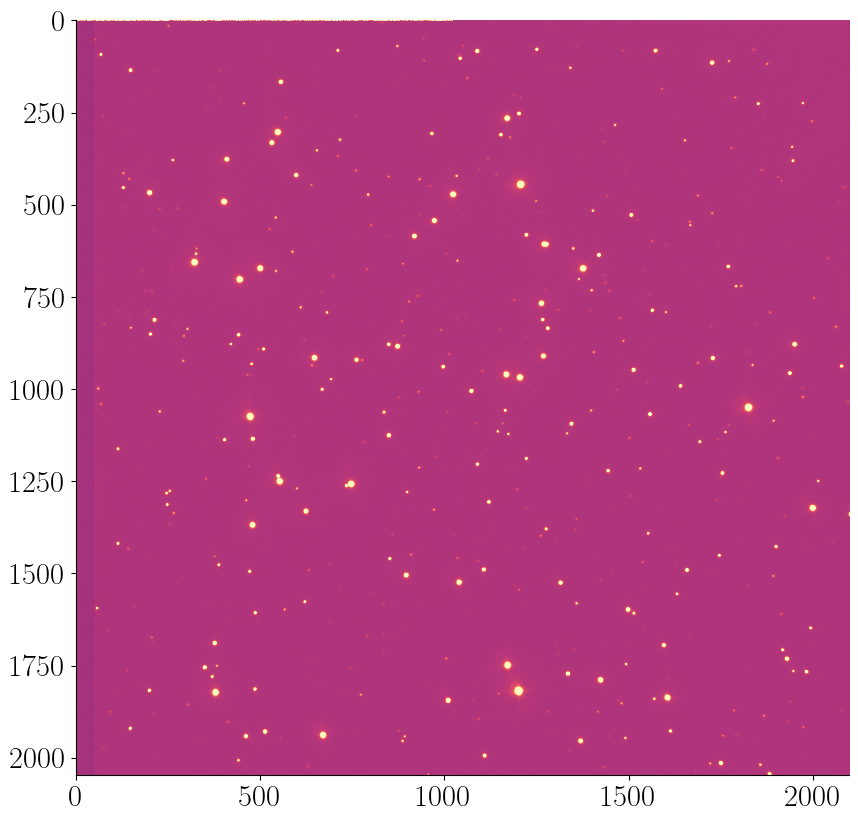

(7, 2048, 2098)
(2048, 2098)


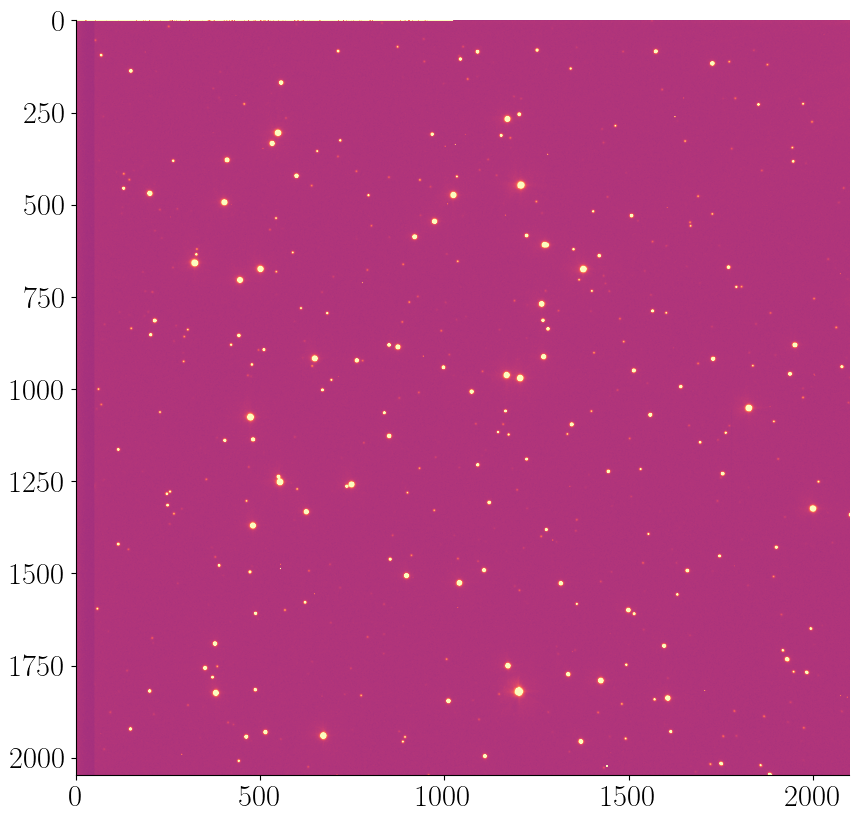

In [3]:
file_names_V = sorted(glob.glob('test_data/NGC2539/V/*fits')); file_names_B = sorted(glob.glob('test_data/NGC2539/B/*fits'))

V_data = quick_average(file_names_V)
B_data = quick_average(file_names_B)

## DAO Starfinder 

In [15]:
def starfinder(data, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = 6., threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        vmin = data.mean() - data.std(); vmax = data.mean() + data.std()
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        plt.imshow(data, cmap = 'magma', vmin = vmin , vmax = vmax)
        plt.show()

    return mst_sources

In [17]:
V_sources = starfinder(V_data, 5, False)
B_sources = starfinder(B_data, 5, False)

print(len(V_sources), len(B_sources))
print(V_sources, len(V_sources))

563 433
 id xcentroid ycentroid  sharpness  ... sky    peak      flux       mag    
--- --------- ---------- ---------- ... --- --------- --------- -----------
  1 714.44912 0.73764394 0.20653155 ...   0 510.16667 101.07995  -5.0116625
  2 2094.8086  2.1924801  0.4047497 ...   0 408.66667 54.674094   -4.344454
  3 828.09344  6.0750774 0.45015205 ...   0       448 5.6050002  -1.8714391
  4 596.32103   9.016695 0.46499281 ...   0 430.66667 3.0517805  -1.2113832
  5 250.08561  15.034449 0.52061698 ...   0 515.33333 14.106679   -2.873562
  6 1290.2653  20.165467 0.60612608 ...   0 425.16667 1.8079344 -0.64295668
  7 941.48805   48.83971 0.52218044 ...   0 460.83333  6.774864  -2.0772515
  8 51.556781  52.463425 0.49982808 ...   0     478.5  10.83764  -2.5873368
  9 870.44337  70.110995 0.53214026 ...   0       668 34.552545  -3.8462001
 10 1048.1986  69.886822  0.5484703 ...   0 466.83333 7.5948693  -2.2013008
...       ...        ...        ... ... ...       ...       ...         ...
553 

## Aperture Photometry 

In [6]:
from photutils import * 

In [7]:
def aper_photometry(data, sources):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=6)
    annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
    apers = (aperture, annulus_aperture)

    phot_table = aperture_photometry(data, apers)
    print(annulus_aperture)

    # We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
    # in the aperture to get the total background counts within each aperture 
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area()
    bkg_sum = bkg_mean*aperture.area

    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum

    return -2.5*np.log10(final_sum)

In [8]:
# V_mag = aperture_photometry(V_data, V_sources)
# B_mag = aperture_photometry(B_data, B_sources)

In [9]:
sources = V_sources; data = V_data
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# Aperture and Annulus 
aperture = CircularAperture(positions, r=6)
annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
apers = (aperture, annulus_aperture)

phot_table = aperture_photometry(data, apers)

# We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
# in the aperture to get the total background counts within each aperture 
bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area
bkg_sum = bkg_mean*aperture.area

# # Now we get the final table of background subtracted counts within each aperture
final_sum = phot_table['aperture_sum_0'] - bkg_sum

V_mag = -2.5*np.log10(final_sum)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


In [10]:
sources = B_sources; data = B_data
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# Aperture and Annulus 
aperture = CircularAperture(positions, r=6)
annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
apers = (aperture, annulus_aperture)

phot_table = aperture_photometry(data, apers)

# We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
# in the aperture to get the total background counts within each aperture 
bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area
bkg_sum = bkg_mean*aperture.area

# # Now we get the final table of background subtracted counts within each aperture
final_sum = phot_table['aperture_sum_0'] - bkg_sum

B_mag = -2.5*np.log10(final_sum)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


## CMD Plot

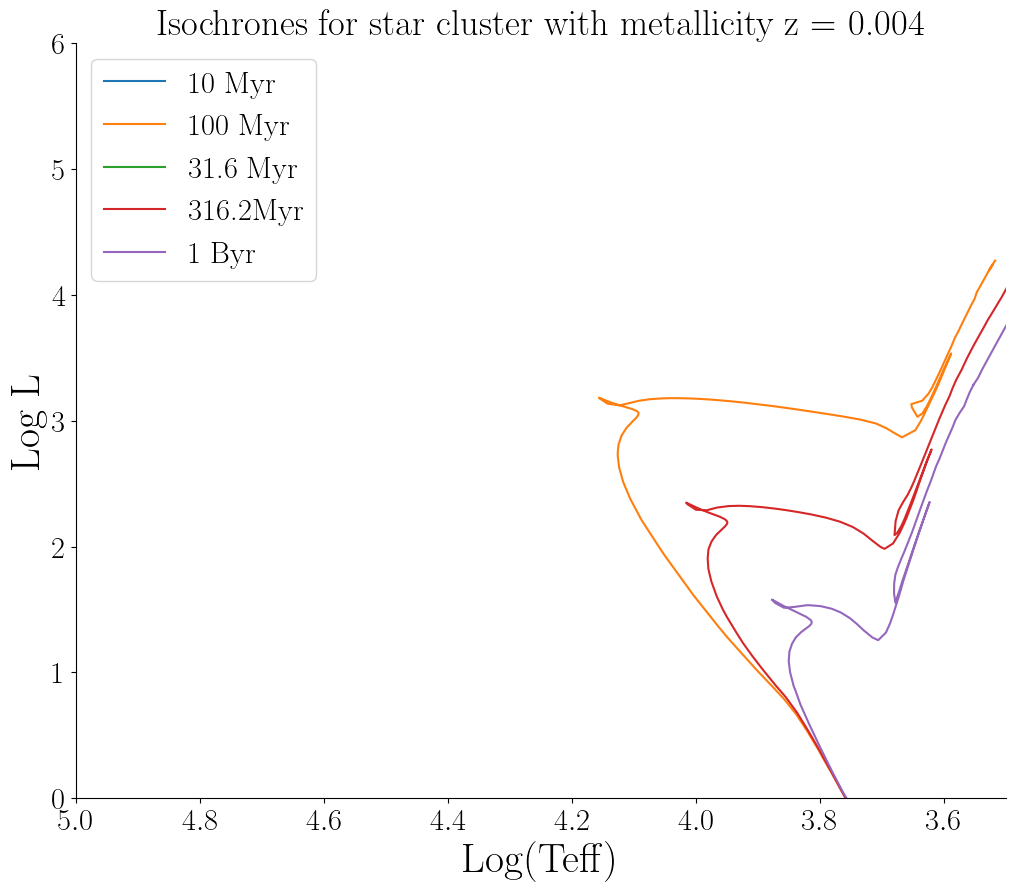

In [11]:
loga,logl,logte = np.loadtxt('test_data/isochrone_z003.dat', usecols=(0 , 3, 4), unpack =True)
Mb1, Mv1 =  np.loadtxt('test_data/isochrone_z003.dat', usecols=(8,9), unpack=True)

w7 = np.where(loga == 7.0)#10**7 
w7_5 = np.where(loga == 7.5)
w8 = np.where(loga == 8.0)
w8_5 = np.where(loga == 8.5)
w9 = np.where(loga == 9.0)

plt.figure(figsize=[12,10])
    
plt.plot(logte[w7], logl[w7],label='10 Myr')
plt.plot(logte[w8], logl[w8],label='100 Myr')
plt.plot(logte[w7_5], logl[w7_5],label='31.6 Myr')
plt.plot(logte[w8_5], logl[w8_5],label='316.2Myr')
plt.plot(logte[w9], logl[w9],label='1 Byr')

ages = [w7, w8, w9]

plt.xlabel('Log(Teff)')
plt.ylabel('Log L')
plt.axis([5.0,3.5,0,6])
plt.title("Isochrones for star cluster with metallicity z = 0.004")
plt.legend()
plt.savefig("cmdconstmetallicity.pdf")

Text(0.5, 0, 'B - V')

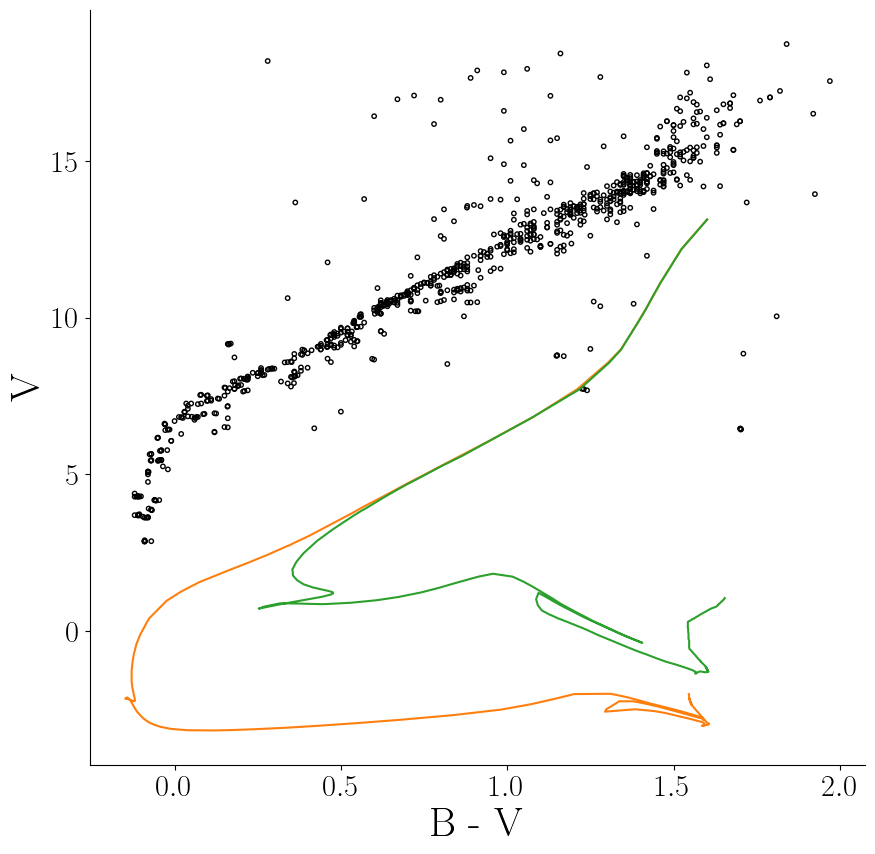

In [12]:
M45v, M45bv = np.loadtxt("test_data/m45.dat", usecols=(2,3), unpack=True)

for i in range(0, len(ages)):
    B = Mb1[ages[i]]; V = Mv1[ages[i]] 
    plt.plot((B-V), V)
    
plt.scatter(M45bv, M45v, facecolor = 'none', edgecolors= 'k', s = 10)
plt.ylabel('V'); plt.xlabel('B - V')
